# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt

from helpers.dataset import ContrastiveCIFAR10
from helpers.config import TrainingConfig, ResNetConfig, SSLConfig
from helpers.trainer import train
from models.encoder import ResNet
from models.ssl import SSLModel
from models.loss import NTXent, DCL, VICReg

# Load data

In [3]:
train_cfg = TrainingConfig()

ds_train = ContrastiveCIFAR10("../data/cifar10/", train=True, download=True)
dl_train = DataLoader(
    ds_train,
    batch_size=train_cfg.batch_size,
    num_workers=train_cfg.num_workers,
    pin_memory=True,
    shuffle=True,
)

ds_test = CIFAR10("../data/cifar10/", train=False)

print(train_cfg, end="\n\n")
print(ds_train, end="\n\n")
print(ds_test)

Files already downloaded and verified
TrainingConfig(device=device(type='cuda'), batch_size=16, num_workers=4, learning_rate=0.002, weight_decay=1e-06, max_epoch=100)

Dataset ContrastiveCIFAR10
    Number of datapoints: 50000
    Root location: ../data/cifar10/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 RandomResizedCrop(size=(32, 32), scale=(0.3, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BICUBIC, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 RandomApply(    ColorJitter(brightness=(0.6, 1.4), contrast=(0.9, 1.1), hue=(-0.1, 0.1)))
                 RandomGrayscale(p=0.1)
                 ToDtype(scale=True)
                 Normalize(mean=[0.5], std=[0.5], inplace=False)
           )

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data/cifar10/
    Split: Test


torch.Size([3, 32, 32])


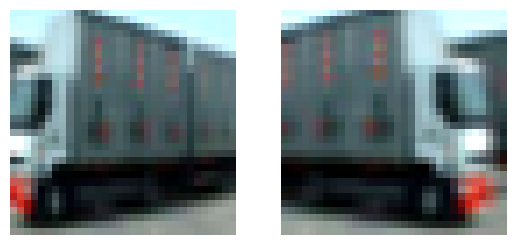

In [4]:
def imshow(*imgs):
    _, axes = plt.subplots(1, len(imgs))

    for i, img in enumerate(imgs):
        img = img / 2 + 0.5  # unnormalize
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_axis_off()

    plt.show()


idx = np.random.choice(range(len(ds_train)))
x_1, x_2 = ds_train[idx]

print(x_1.shape)
imshow(x_1, x_2)

# Train model

In [5]:
resnet_cfg = ResNetConfig(in_channels=3, num_stage=3, num_block_per_stage=3)
ssl_cfg = SSLConfig(dim_embedding=64 * 2 ** (3 - 1), num_hidden_proj=2)

encoder = ResNet(**resnet_cfg.__dict__)
model = SSLModel(encoder, **ssl_cfg.__dict__)

print(resnet_cfg, end="\n\n")
print(ssl_cfg, end="\n\n")

print(f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,d} learnable params")
print(f"{sum(p.numel() for p in model.parameters()):,d} total params")
print(model)

ResNetConfig(in_channels=3, num_stage=3, num_block_per_stage=3, out_channels_first=64, kernel_size_first=7)

SSLConfig(dim_embedding=256, num_hidden_proj=2, dim_hidden_proj=None)

4,727,616 learnable params
4,727,616 total params
SSLModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (residual_blocks): Sequential(
      (0): ResidualBlock(
        (_layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [6]:
loss_func = VICReg(normalize=True)
# loss_func = DCL()
# loss_func = NTXent()

loss_history = train(
    model,
    loss_func=loss_func,
    dl_train=dl_train,
    lr=train_cfg.learning_rate,
    max_epoch=2,
    device=train_cfg.device,
    weight_decay=train_cfg.weight_decay
)

Epoch 1 - step 3125/3125 - lr: 0.0110 -  loss: 23.8763
Epoch 2 - step 3125/3125 - lr: 0.0020 -  loss: 23.8657
